# 🫀Classifying Attributes that Best Predict Heart Disease

## Introduction

**Heart disease** is a term used to describe a range of heart conditions, and according to **Statistics Canada**, it is the second leading cause of death in 2019, accounting for 18.5% of all deaths. So by using the Heart Disease data set, we will determine the three attributes (i.e. characteristics or factors) that can best predict the presence of heart disease in a person. 

The data set contains four datasets concerning heart-disease related characteristics, and each data set contains 14 attributes organized into 14 variables and 302 observations. All the data is of type double, and they were collected from the following institutes:

Cleveland Clinic Foundation (cleveland.data)
Hungarian Institute of Cardiology, Budapest (hungarian.data)
V.A. Medical Center, Long Beach, CA (long-beach-va.data)
University Hospital, Zurich, Switzerland (switzerland.data)



## Algorithm of choice: KNN Classification

We will be using KNN categorical classification. We chose our predictors and we used cross validation to find K, the number of neighbors that give us the highest prediction accuracy. KNN performs predictions by choosing the K nearest neighbors for each point, and classifies the point according to the majority of the classification around it. Our model will determine the best K for each predictors (i.e., age, cholesterol level, resting blood pressure, maximum heart rate) using a 10-fold cross-validation. Then, the model will classify the unknown data by comparing it with K nearest points.

## Method Overview

For this project, we will use cleveland.data and the following **five factors:** (1) age, (2) resting blood pressure, (3) cholesterol level, (4) maximum heart rate achieved, and (5) the presence of heart disease. We chose these attributes because previous research from Texas Heart Institute indicates these as some of the risk factors in developing heart disease.
 
To prepare our data, we first loaded tidymodels and other necessary packages and files to help us complete our K-nearest neighbors classification. The heart disease data was loaded using the read_csv function, and variable names were given according to the data description. We also set the seed to make our code reproducible.
  
Next, predictor variables were chosen by selecting and filtering for the attributes we will be considering and mutating them to be more easily read (i.e., changing the presence of heart disease to be represented by 1, and the absence of heart disease to be represented by 0). To do so, we filtered for == 0 and >0, respectively, gave them new column names and separately stored them in new data sets. To create the dataset we will be working with for this project, the rebind function was applied to combine the two newly made ones. We then balanced the data, so each new dataset contains the same amount of data. Originally, we included sex as an attribute, but since it is a categorical variable and cannot be used for classification, we removed it. We also converted the presence of heart disease variable into a factor.

In building our k-nearest neighbor model, we split the data into a training and testing set, with 66% of the data being used for the training set — following the textbook’s recommended 2:1 ratio. Stratifying around the presence_of_h_d variable and using the other four attributes as predictors, we scaled and centered the predictors to start with a mean of 0 and standard deviation of 1, so they have similar power in influence on each classification. A validation set was also made to perform 10-fold cross-validation. Then, we created a model specification by specifying the use of the “kknn” package for classification and used tune() for the neighbors argument. The model specification, along with the scaling and centering recipe, were put in a workflow and fitted onto our data. To choose a K value that will give us the best accuracy for our classifier, we applied the collect_metrics function to calculate the mean and standard validation values, filtered for the accuracy, and plotted the accuracy against K with a point line chart. Our chosen K was used to retrain our model.

To determine the top three attributes that can best predict the presence of heart disease, we built a classifier for each predictor and chose the predictors with the highest accuracies. A bar chart was used to visualize our results.

## Loading the Dataset

To conduct our analysis, we first loaded tidy models and other necessary packages and files to help us complete our K-nearest neighbors classification. 

In [64]:
library(tidyverse)
library(repr)
library(broom)
library(GGally)
library(tidymodels)
library(data.table)
options(repr.matrix.max.rows = 6)

#### Setting the seed:

We set the seed so our code is reproduceable and loaded in our heart disease data using the read_csv function.

In [45]:
set.seed(2000)

heart_disease <- read_csv(url('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'))

Warning message:
“Duplicated column names deduplicated: '1.0' => '1.0_1' [3], '1.0' => '1.0_2' [6], '0.0' => '0.0_1' [12]”
Parsed with column specification:
cols(
  `63.0` = col_double(),
  `1.0` = col_double(),
  `1.0_1` = col_double(),
  `145.0` = col_double(),
  `233.0` = col_double(),
  `1.0_2` = col_double(),
  `2.0` = col_double(),
  `150.0` = col_double(),
  `0.0` = col_double(),
  `2.3` = col_double(),
  `3.0` = col_double(),
  `0.0_1` = col_character(),
  `6.0` = col_character(),
  `0` = col_double()
)



## Data Wrangling

Next, we wrangled the data by selecting and filtering for the attributes we will be considering, and mutating it to be more easily read. We mutate the presence of heart disease to 1 and absence of heart disease to 0. We did this by separately assigning the name using filter and mutate function and we rebind the datasets to one.  Originally, we included sex as an attribute, but since it is a categorical variable and cannot be used for classification, we removed it. We also converted the presence of heart disease variable into a factor.

In [3]:
set.seed(2000)

names(heart_disease) <- c("age", "sex", "chest_pain_type", "resting_bp", "chol", "fasting_blood_sugar", "resting_electrocardiographic_results", "maximum_heart_rate_achieved", "exercise_induced_angina", "oldpeak", "slope", "ca", "thal", "presence_of_h_d")

# Select variables
heart_disease_select_data <- heart_disease %>%
select(-chest_pain_type, -fasting_blood_sugar, -resting_electrocardiographic_results, -exercise_induced_angina, -oldpeak, -slope, -thal, -ca, -sex)

# Make target variable binary
heart_disease_data_0 <- heart_disease_select_data %>%
filter(presence_of_h_d == 0)

heart_disease_data_1 <- heart_disease_select_data %>%
filter(presence_of_h_d > 0) %>%
mutate(presence_of_h_d = 1)

heart_disease_data <- rbind(heart_disease_data_0, heart_disease_data_1) %>% 
mutate(presence_of_h_d = as_factor(presence_of_h_d))

Then we scaled and balanced the data so that the number of presence of heart disease and absence of heart disease data are the same. We did this to give the presence of heart disease data more voting power, otherwise the prediction would usually be absence of heart disease.

In [4]:
set.seed(2000)
ups_recipe <- recipe(presence_of_h_d~ ., data = heart_disease_data) %>% step_upsample(presence_of_h_d, over_ratio = 1, skip = FALSE) %>% prep()
scaled_data <- bake(ups_recipe, heart_disease_data)
scaled_data %>% group_by(presence_of_h_d) %>% summarize(n = n())

Warning message:
“`step_upsample()` is deprecated as of recipes 0.1.13.
Please use `themis::step_upsample()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”
`summarise()` ungrouping output (override with `.groups` argument)



presence_of_h_d,n
<fct>,<int>
0,163
1,163


Here, we are split the tidied heart disease data into training and testing data. We chose to split 66% of the data for training as it was recommended in the readings to split training to testing in a 2:1 ratio.

In [5]:
set.seed(2000)
heart_split <- initial_split(scaled_data, prop = 0.66, strata = presence_of_h_d) 
training_data <- training(heart_split) 
testing_data <- testing(heart_split)

## Preliminary Exploratory Data Analysis

**Note:** There is no missing data in the training data set.

### Visualization example:

We used ggpairs to visualize the pairwise correlation and distribution between our predictors and target variables.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



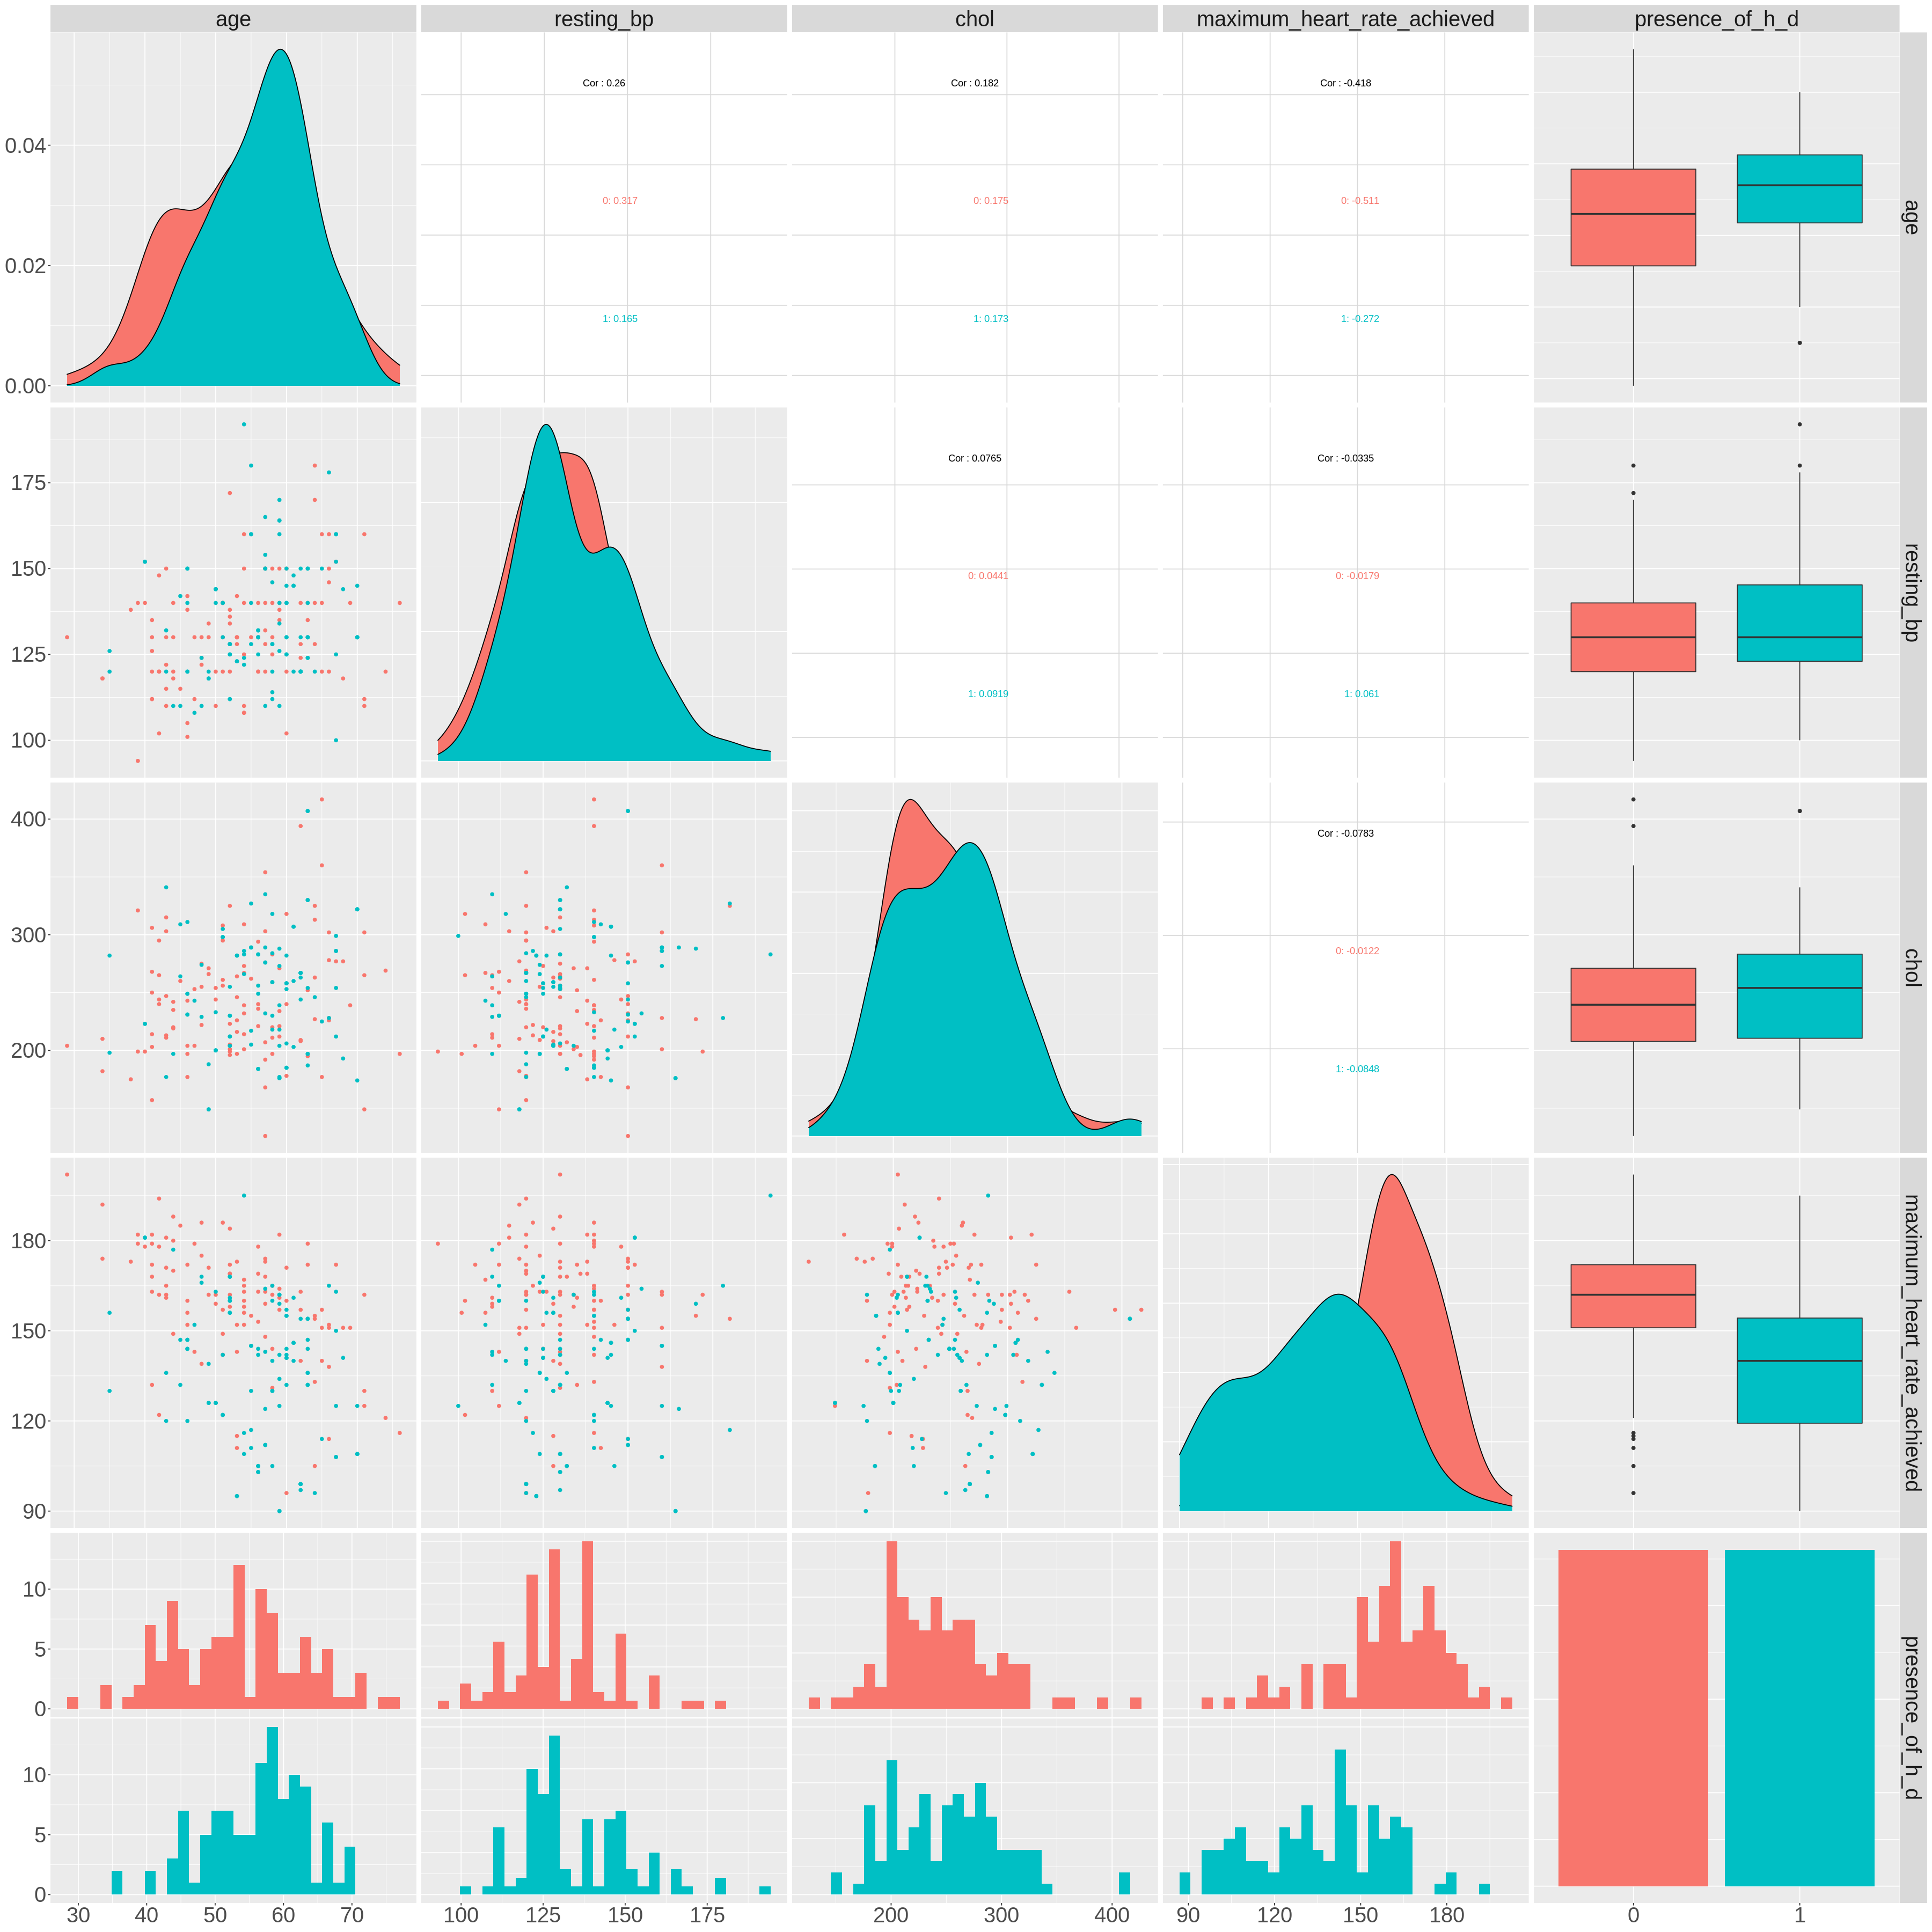

In [8]:
options(repr.plot.width=30,repr.plot.height=30)
    ggpairs(training_data, aes(color=presence_of_h_d)) +
    theme(text=element_text(size=30))
options(repr.plot.width=10,repr.plot.height=10)

**Figure 1:** ggplot of predictors and target variables

## Training the Model

This is for all predictors and will serve as our baseline reference.

#### 1. Making the recipe

In [33]:
set.seed(2000)
recipe <- recipe(presence_of_h_d ~ ., data = training_data) %>% step_scale(all_predictors()) %>% step_center(all_predictors())
recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Operations:

Scaling for all_predictors()
Centering for all_predictors()

#### 2. Cross Validation

In [54]:
train_vfold <- vfold_cv(training_data, v = 10, strata = presence_of_h_d)

#### 3. Training the Classifier

In [35]:
set.seed(2000)

spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
      set_engine("kknn") %>%
      set_mode("classification")
#Fit
training_fit <- workflow() %>%
      add_recipe(recipe) %>%
      add_model(spec) %>%
      tune_grid(resamples = train_vfold, grid = 10) %>%
      collect_metrics() 

#### Validation accuracy table and visualization:

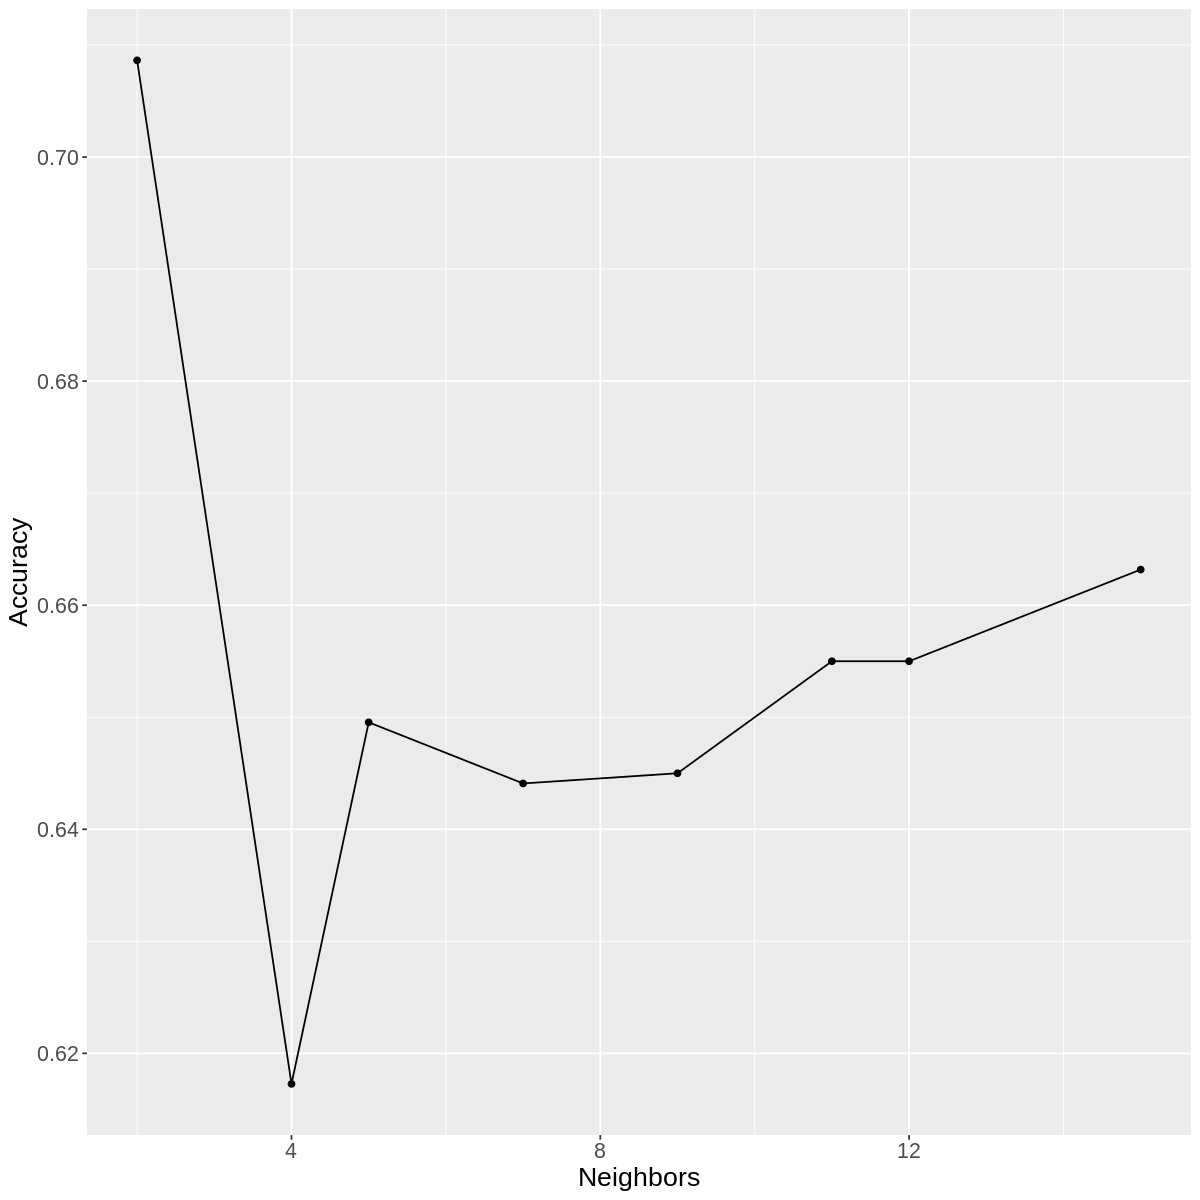

In [36]:
# Validation accuracy table
accuracies <- training_fit %>% 
      filter(.metric == "accuracy")

#Validation visualization
cross_val_plot <- accuracies %>%
     ggplot(aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy") +
     theme(text = element_text (size = 16))

cross_val_plot

**Figure 2:** Cross validation visualization plot 

#### Choosing the value of K:

In [37]:
k_for_all <- accuracies %>% arrange(desc(mean)) %>% head(1) %>% pull(neighbors)
accuracies_age

spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_for_all) %>%
      set_engine("kknn") %>%
      set_mode("classification")

fit <- workflow() %>%
      add_recipe(recipe) %>%
      add_model(spec) %>%
      fit(data = training_data)

ERROR: Error in eval(expr, envir, enclos): object 'accuracies_age' not found


#### Showing the prediction accuracy:

In [ ]:
predictions_all <-predict(fit, testing_data) %>% bind_cols(testing_data) %>% metrics(truth = presence_of_h_d, estimate = .pred_class)
predictions_all

#### Showing the confusion matrix:

In [32]:
predictions_matixs <- predict(fit, testing_data) %>% bind_cols(testing_data)%>%
     conf_mat(truth=presence_of_h_d,estimate=.pred_class)
predictions_matixs

          Truth
Prediction  0  1
         0 37 16
         1 18 39

## Training the Model for each Individual Variable:

**Note:** The code below is similar in structure for all four variables, so we will only label and comment on the code for the first predictor. 

### 1. Using only Age (age) as a predictor

#### Making the recipe, cross validation, training the Classifier

In [53]:
set.seed(2000)
recipe_age <- recipe(presence_of_h_d ~ age, data = training_data) %>% step_scale(all_predictors()) %>% step_center(all_predictors())

train_vfold_age <- vfold_cv(training_data, v = 10, strata = presence_of_h_d)

spec_age <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
      set_engine("kknn") %>%
      set_mode("classification")

training_fit_age <- workflow() %>%
      add_recipe(recipe_age) %>%
      add_model(spec_age) %>%
      tune_grid(resamples = train_vfold_age, grid = 10) %>%
      collect_metrics() 

#### Validation accuracy table and visualization:

In [50]:
# Validation accuracy table
accuracies_age <- training_fit_age %>% 
      filter(.metric == "accuracy")
#Validation visualization
cross_val_plot_age <- accuracies_age %>%
     ggplot(aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy") +
     theme(text = element_text (size = 16))
cross_val_plot_age

ERROR: Error in eval(lhs, parent, parent): object 'training_fit_age' not found


#### Choosing the value of K:

In [48]:
k_for_all_age <- accuracies_age %>% arrange(desc(mean)) %>% head(1) %>% pull(neighbors)
accuracies_age

spec_age_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = k_for_all_age) %>%
      set_engine("kknn") %>%
      set_mode("classification")

fit_age <- workflow() %>%
      add_recipe(recipe_age) %>%
      add_model(spec_age_tune) %>%
      fit(data = training_data)

ERROR: Error in eval(lhs, parent, parent): object 'accuracies_age' not found


#### Showing the prediction accuracy and matrix:

In [47]:
#accuracy
predictions_all_age <-predict(fit_age, testing_data) %>% bind_cols(testing_data) %>% metrics(truth = presence_of_h_d, estimate = .pred_class)
predictions_all
#matrix
predictions_matixs_age <- predict(fit_age, testing_data) %>% bind_cols(testing_data)%>%
     conf_mat(truth=presence_of_h_d,estimate=.pred_class)
predictions_matixs_age

ERROR: Error in predict(fit_age, testing_data): object 'fit_age' not found


#### Pull results

In [46]:
age_accuracy<-predictions_all_age %>% filter(.metric == "accuracy") %>% pull(.estimate)

ERROR: Error in eval(lhs, parent, parent): object 'predictions_all_age' not found


**Figure 3:** Cross validation for age

### 2. Using only Resting Blood Pressure (resting_bp) as a predictor:

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          1

Operations:

Scaling for all_predictors()
Centering for all_predictors()

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5181818,10,0.03894853,Model1
3,accuracy,binary,0.5186364,10,0.03268270,Model2
4,accuracy,binary,0.5372727,10,0.02941736,Model3
⋮,⋮,⋮,⋮,⋮,⋮,⋮
11,accuracy,binary,0.5431818,10,0.03203569,Model7
12,accuracy,binary,0.5568182,10,0.03425214,Model8
15,accuracy,binary,0.5709091,10,0.03613057,Model9


[1] 15

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6181818
kap,binary,0.2363636


          Truth
Prediction  0  1
         0 49 36
         1  6 19

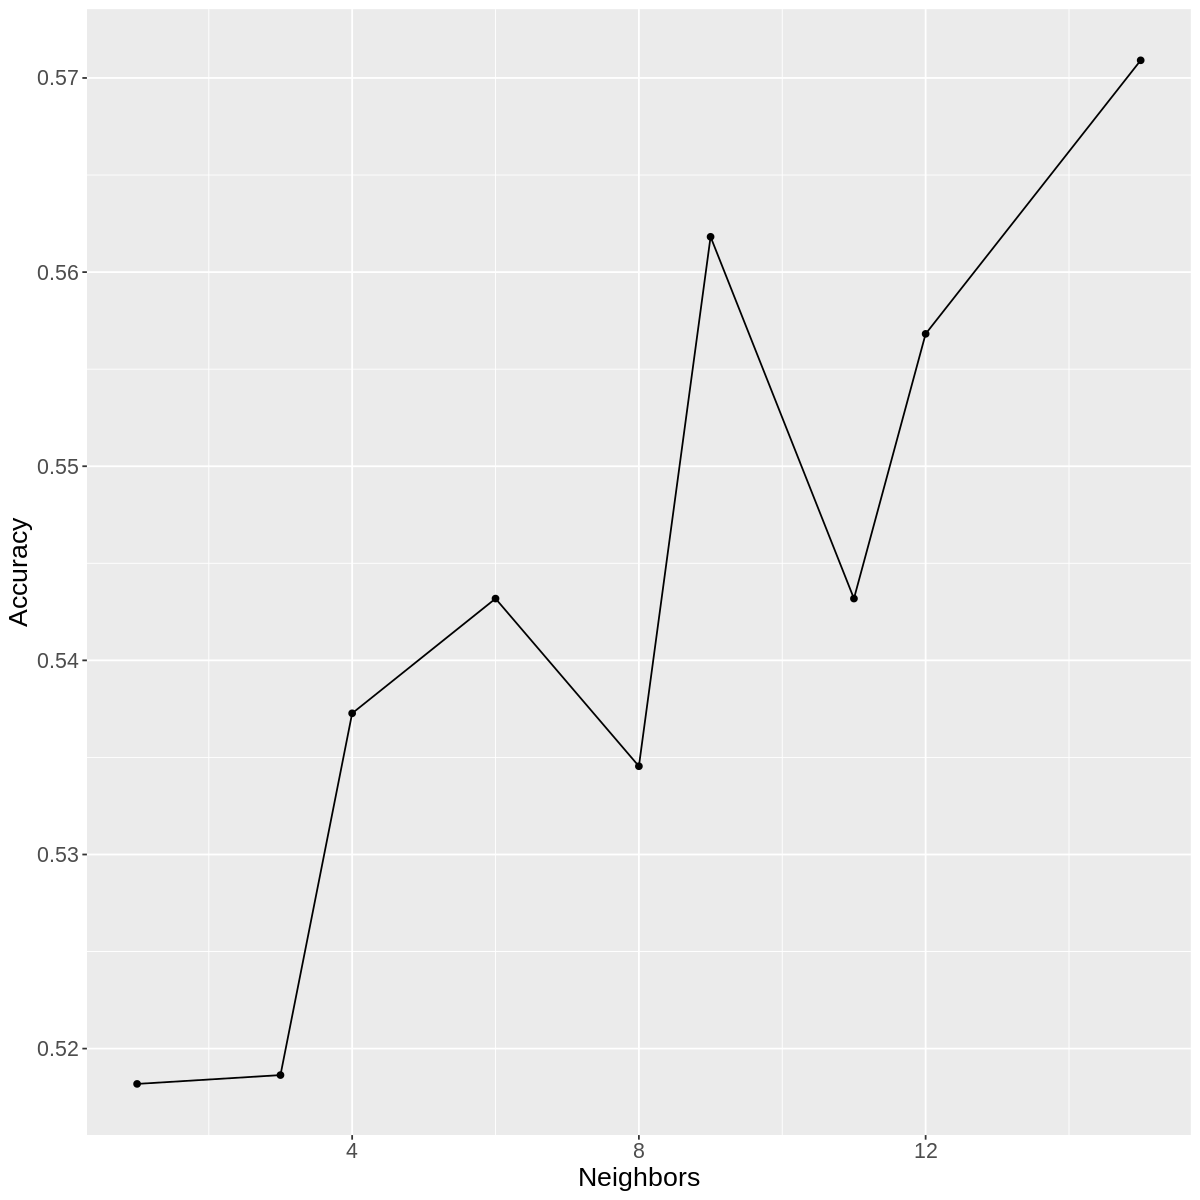

In [55]:
set.seed(2000)

#Making the recipe
recipe <- recipe(presence_of_h_d ~ resting_bp, data = training_data) %>% step_scale(all_predictors()) %>% step_center(all_predictors())

#Cross validation
train_vfold <- vfold_cv(training_data, v = 10, strata = presence_of_h_d)

#Training the Classifier
spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
      set_engine("kknn") %>%
      set_mode("classification")

training_fit <- workflow() %>%
      add_recipe(recipe) %>%
      add_model(spec) %>%
      tune_grid(resamples = train_vfold, grid = 10) %>%
      collect_metrics() 

# Validation accuracy table
accuracies <- training_fit %>% 
      filter(.metric == "accuracy")

#Validation visualization
cross_val_plot <- accuracies %>%
     ggplot(aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy") +
     theme(text = element_text (size = 16))

cross_val_plot

# Choosing the value of K
k_for_all <- accuracies %>% arrange(desc(mean)) %>% head(1) %>% pull(neighbors)
accuracies

spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_for_all) %>%
      set_engine("kknn") %>%
      set_mode("classification")

fit <- workflow() %>%
      add_recipe(recipe) %>%
      add_model(spec) %>%
      fit(data = training_data)

#accuracy
predictions_all <-predict(fit, testing_data) %>% bind_cols(testing_data) %>% metrics(truth = presence_of_h_d, estimate = .pred_class)
predictions_all

#matrix
predictions_matixs <- predict(fit, testing_data) %>% bind_cols(testing_data)%>%
     conf_mat(truth=presence_of_h_d,estimate=.pred_class)
predictions_matixs

#Pull results
bp_accuracy<-predictions_all %>% filter(.metric == "accuracy") %>% pull(.estimate)

**Figure 4:** Cross validation for resting blood pressure

### 3. Using only Cholesterol (chol) as a predictor

In [ ]:
set.seed(2000)
#Making the recipe
recipe <- recipe(presence_of_h_d ~ chol, data = training_data) %>% step_scale(all_predictors()) %>% step_center(all_predictors())

#Cross validation
train_vfold <- vfold_cv(training_data, v = 10, strata = presence_of_h_d)

#Training the Classifier
spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
      set_engine("kknn") %>%
      set_mode("classification")

training_fit <- workflow() %>%
      add_recipe(recipe) %>%
      add_model(spec) %>%
      tune_grid(resamples = train_vfold, grid = 10) %>%
      collect_metrics() 

# Validation accuracy table
accuracies <- training_fit %>% 
      filter(.metric == "accuracy")

#Validation visualization
cross_val_plot <- accuracies %>%
     ggplot(aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy") +
     theme(text = element_text (size = 16))

cross_val_plot

# Choosing the value of K
k_for_all <- accuracies %>% arrange(desc(mean)) %>% head(1) %>% pull(neighbors)
accuracies

spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_for_all) %>%
      set_engine("kknn") %>%
      set_mode("classification")

fit <- workflow() %>%
      add_recipe(recipe) %>%
      add_model(spec) %>%
      fit(data = training_data)

predictions_all <-predict(fit, testing_data) %>% bind_cols(testing_data) %>% metrics(truth = presence_of_h_d, estimate = .pred_class)
#predictions_all
predictions_matixs <- predict(fit, testing_data) %>% bind_cols(testing_data)%>%
     conf_mat(truth=presence_of_h_d,estimate=.pred_class)
predictions_matixs
#Pull results
chol_accuracy<-predictions_all %>% filter(.metric == "accuracy") %>% pull(.estimate)

**Figure 5:** Cross validation for cholestrol

### 4. Using only Maximum heart rate(HR) as a predictor

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6159091,10,0.02923300,Model1
3,accuracy,binary,0.6590909,10,0.03030303,Model2
4,accuracy,binary,0.6727273,10,0.02494254,Model3
⋮,⋮,⋮,⋮,⋮,⋮,⋮
11,accuracy,binary,0.7277273,10,0.01964387,Model7
12,accuracy,binary,0.7368182,10,0.01938506,Model8
15,accuracy,binary,0.7463636,10,0.02384908,Model9


          Truth
Prediction  0  1
         0 34 18
         1 21 37

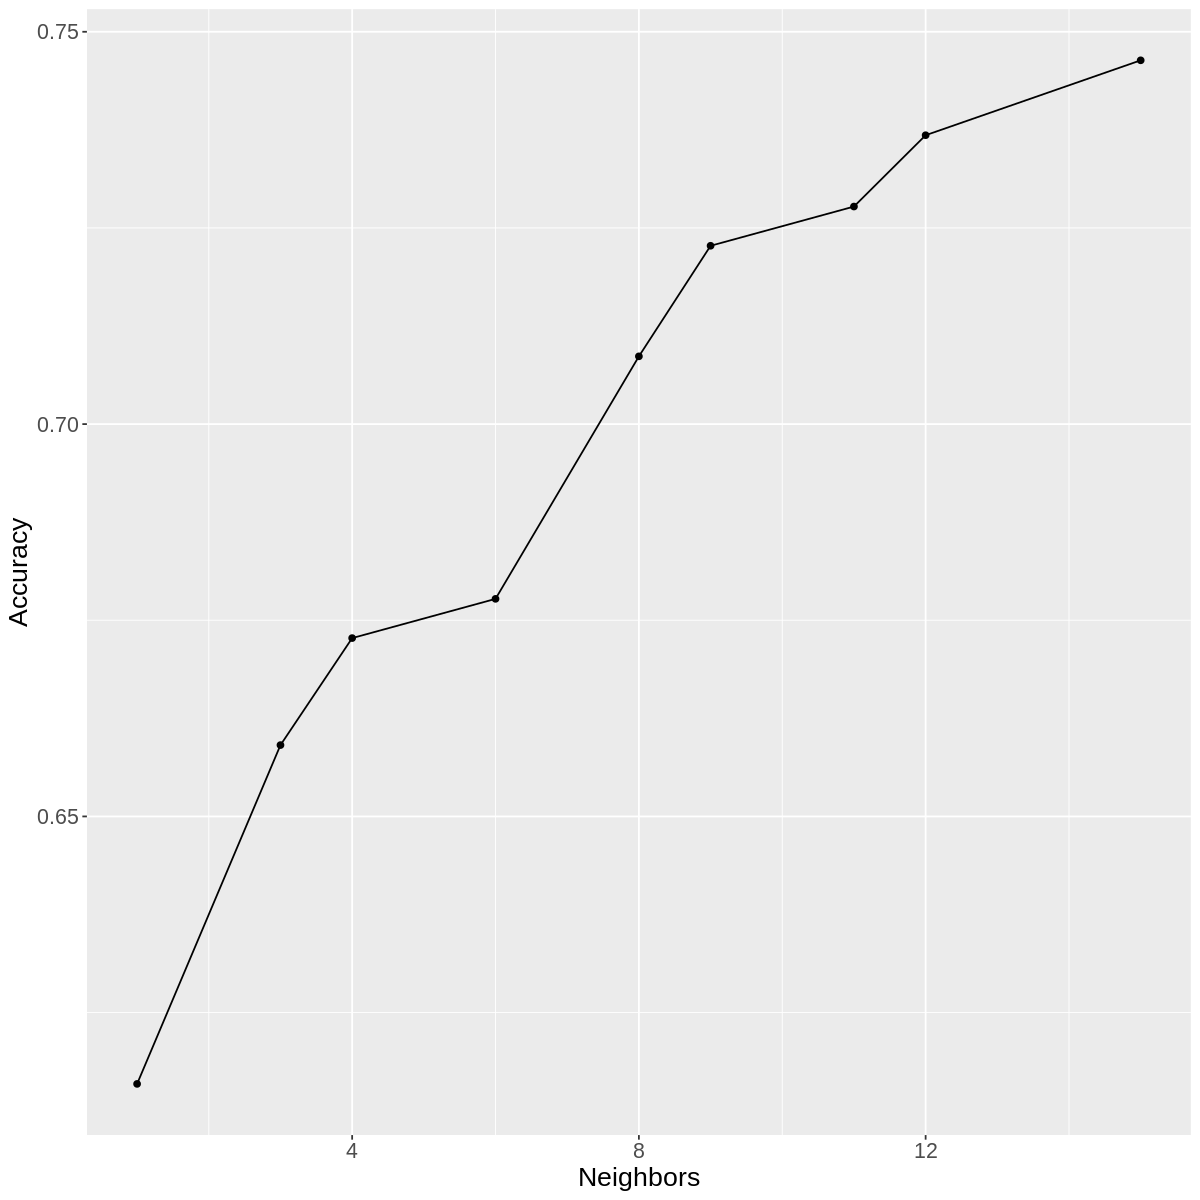

In [63]:
set.seed(2000)
#Making the recipe
recipe <- recipe(presence_of_h_d ~ maximum_heart_rate_achieved, data = training_data) %>% step_scale(all_predictors()) %>% step_center(all_predictors())

#Cross validation
train_vfold <- vfold_cv(training_data, v = 10, strata = presence_of_h_d)

#Training the Classifier
spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
      set_engine("kknn") %>%
      set_mode("classification")

training_fit <- workflow() %>%
      add_recipe(recipe) %>%
      add_model(spec) %>%
      tune_grid(resamples = train_vfold, grid = 10) %>%
      collect_metrics() 
# Validation accuracy table
accuracies <- training_fit %>% 
      filter(.metric == "accuracy")
#Validation visualization
cross_val_plot <- accuracies %>%
     ggplot(aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy") +
     theme(text = element_text (size = 16))

cross_val_plot

# Choosing the value of K
k_for_all <- accuracies %>% arrange(desc(mean)) %>% head(1) %>% pull(neighbors)
accuracies

spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_for_all) %>%
      set_engine("kknn") %>%
      set_mode("classification")

fit <- workflow() %>%
      add_recipe(recipe) %>%
      add_model(spec) %>%
      fit(data = training_data)

predictions_all <-predict(fit, testing_data) %>% bind_cols(testing_data) %>% metrics(truth = presence_of_h_d, estimate = .pred_class)
#predictions_all
predictions_matixs <- predict(fit, testing_data) %>% bind_cols(testing_data)%>%
     conf_mat(truth=presence_of_h_d,estimate=.pred_class)
predictions_matixs
#Pull results
heart_rate_accuracy<-predictions_all %>% filter(.metric == "accuracy") %>% pull(.estimate)

**Figure 5:** Cross validation for maximum heart rate

## Results

#### Tibble Summary

In [42]:
tb <-tibble( `Predictor` = c("Age", "BP", "Chol", "HR"), 'Accuracy' = c(age_accuracy, bp_accuracy, chol_accuracy, heart_rate_accuracy))
tb

ERROR: Error in eval_tidy(xs[[j]], mask): object 'age_accuracy' not found


#### Visualization:

In [ ]:
plot <- ggplot(tb, aes(x = Predictor, y = Accuracy)) +
        geom_bar(stat="identity") +
        labs(x = "Predictors",y = "Accuracy") +
        ggtitle("Accuracy relative to Predictors") +
        theme(text = element_text(size = 14))
plot

**Figure 6:** Bar chart showing the accuracy of all individual predictors

Out of our four predictors, the three with the highest accuracy are a person’s maximum heart rate (64.55%), resting blood pressure (61.81%), and cholesterol level (61.81%). Age has the weakest correlation, with a 59.09% accuracy in predicting the presence of heart disease.

Looking at the confusion matrix for single predictors, maximum heart rate accurately predicted 37 patients having heart disease and 34 patients without heart disease. It also yielded 18 false negatives and 21 false positives. For blood pressure, there are 19 accurate predictions for heart disease, 49 accurate predictions for no heart disease, 36 false negatives, and 6 false positives. On the other hand, cholesterol has 29 accurate predictions for heart disease, 39 accurate predictions for no heart disease, 26 cases of false negatives, and 16 cases of false positives.

When combining all four predictors in our model into one classifier, the overall accuracy increases to 69.09%. Results from this confusion matrix indicate 39 accurately predicted cases of heart disease and 37 accurately predicted cases of no heart disease, as well as 16 false negatives and 18 false positives. Despite providing more accurate predictions than any single predictor, the overall accuracy is not very high. 

## Discussion

Results indicate that **maximum heart rate** is the strongest predictor in predicting the presence of heart disease, followed by cholesterol level and resting blood pressure, and age. For each of the predictors, the confusion matrix for maximum heart rate shows the number of accurate positives and accurate negatives to be two times greater than false positives and false negatives. The prediction for blood pressure and cholesterol level have the same accuracy, but their confusion matrix shows different values. Blood pressure (19/55) has a lower accuracy in predicting the presence of heart disease compared to cholesterol (29/55). Thus, we can conclude that cholesterol level is the second strongest predictor and resting blood pressure is third. 
     
This is **not** what we expect to find since we expected cholesterol level to be the strongest. According to past research, cholesterol level should have the strongest correlation with heart disease because high cholesterol levels cause plaque to build up on the artery wall and limit the blood supply to the heart. We made our prediction based on this information. However, our data shows that only using cholesterol level as the predictor has an accuracy of 61.81%. It is also surprising to find age as the weakest predictor of heart disease, having an accuracy of only 59.09%, because old age increases the risk of having heart disease since our heart muscles weaken and become more susceptible to damage. We also did not expect maximum heart rate to give us the most accurate prediction of someone having heart disease. Despite that, it is reasonable because high maximum heart rate can be caused by factors like high cholesterol level, age, obesity, and can be hereditary. 

#### Implications of Findings

These findings emphasize what people should look out for when trying to decrease the risks of developing heart disease. When taking care of one’s health, our data and results suggest individuals to pay more attention to their heart rate. Although high cholesterol level and age are some of the factors that contribute to increased heart rate, heart rate itself is important in diagnosing heart disease. Essentially, cholesterol level and age increases the risks of developing heart disease, but our heart rates have a larger role in helping us determine if we have any type of heart disease. 

#### Future Questions

Our results prompt us to ask what causes the low accuracy of the cholesterol level predictor since it is supposed to be correlated to heart disease, and out of all the factors, which three have the strongest correlation to maximum heart rate? Additionally, how do the classified attributes determining the presence of heart disease differ between demographics? 

## References

Centers for Disease Control and Prevention. (2021, September 27). About heart disease. Centers for Disease Control and Prevention. Retrieved April 9, 2022, from https://www.cdc.gov/heartdisease/about.htm

Government Of Canada, S. C. (2020, November 26). Table 1 leading causes of death in Canada, 2019 . Leading causes of death in Canada, 2019. Retrieved April 9, 2022, from https://www150.statcan.gc.ca/n1/daily-quotidien/201126/t001b-eng.htm

Heart disease risk factors. Texas Heart Institute. (2020, September 30). Retrieved April 9, 2022, from https://www.texasheart.org/heart-health/heart-information-center/topics/heart-disease-risk-factors/

Types of heart disease. Heart and Stroke Foundation of Canada. (n.d.). Retrieved April 9, 2022, from https://www.heartandstroke.ca/heart-disease/what-is-heart-disease/types-of-heart-disease

UCI Machine Learning Repository: Heart disease data set. (n.d.). Retrieved April 9, 2022, from https://archive.ics.uci.edu/ml/datasets/Heart+Disease